# Распространение тепла

### Условие задачи

**Дано:**
- пластина, в которой распространяется тепло от нескольких источников
  
- коэффициенты диффузии:
    -  основного материала (синий цвет) $D_0 = 1.0$
    -  включений (белый цвет) $D_1 = 10^{-2}$

- размер массива поля температур $NxN$, где $N \in [60, 120, 240, 480, 960]$

- $T_0 = 0$ - начальная температура во всем объеме пластины

- граничные условия на ребрах пластины двух видов:
    - фиксированная температура на ребрах
        - $x = 0$
        - $y = 0$
    - абсолютная теплоизоляция на ребрах
        - $x = 60$
        - $y = 60$

- в массе пластины расположены источники тепла, мощность которых меняется по периодическому закону:
    -  $\dot{q}_i = p_i \cdot (sin(\frac{2\pi}{\theta_i}t) + 1)$
    - источник 0: $p_0 = 100$, $\theta_0 = 43$
    - источник 1: $p_1 = 100$, $\theta_1 = 77$
    
- на пластине расположены 4 пробы (черные точки)
    
- $t_m = 600$ c - общее время моделирования

**Пример схемы пластины для варианта 0**

<img src="var_00.png" width=600/>


**Требуется:**
- согласно уравнению диффузии смоделировать распространение тепла в пластине на заданное время $t_m$ для каждого $N$
- шаг по времени $dt$ подобрать самостоятельно так, чтобы расчетная схема сходилась
- для каждого $N$:
    1. вывести время расчета
    
    2. сохранить в файл(ы) и использовать в пунктах 3-5:
        - температурное поле в конечный момент времени
        - замеры температуры в местах установки проб
        - **сохраненные файлы НЕ загружать в классрум**
    
    3. построить изображение матрицы коэффициентов диффузии

    4. построить цветовую карту поля температур в конечный момент времени
        - подписать оси,
        - отобразить цветовую шкалу `colorbar`,
        - отобразить пробы в виде точек и подписать их номера.

    5. на одном рисунке построить графики температур в местах установки всех четырех проб
        - подписать оси,
        - вывести легенду.

    6. используя быстрое преобразование Фурье, восстановить периоды колебаний температуры в местах установки проб
        - `np.fft.rfft`, `np.fft.rfftfreq`, `scipy.signal.find_peaks`

    7. задокументировать все функции


**Материалы:**

- [Уравнение теплопроводности](https://ru.wikipedia.org/wiki/Уравнение_теплопроводности)
- [Solving 2D heat equation numerically using python](https://levelup.gitconnected.com/solving-2d-heat-equation-numerically-using-python-3334004aa01a)
- [Diffusion Eq 2D with Source](https://www.youtube.com/watch?v=aCRYfvh_bnY)


**Правила оценивания:**

- оценка за корректно выполненный расчет для $N$, баллов из 100:
```
    N    =   60,  120, 240, 480, 960
    g(N) =    5,    5,  10,  30,  50
```
    
- штрафы $p(i)$, баллов:
    - не выведено время расчета - 20
    - не выполнено сохранение результатов в файл(ы) - 20
    - построение графиков не использует сохраненные результаты - 20
    - не построены графики температур в местах установки проб - 20
    - не построена карта поля температур - 20
    - не построена карта коэффициентов диффузии - 10
    - не посчитаны периоды колебаний - 20
    - отсутствует документация функций - 20
    - менее значимые недоработки - 10


- итоговая оценка за задание = $\sum_{k=1}^{4}{g(N_k)} - \sum_{i}{p(i)}$


![image](var_13.png)

In [1]:
import numpy as np
import numba as nb
import matplotlib.pyplot as plt
from tqdm import trange

In [2]:
W, H = 60, 60       # Размеры решетки
D1 = 1.0            # Коэф. диффузии 1
D2 = 0.01           # Коэф. диффузии 2
C = 0.3             # Число Куррента
total_time = 600.0  # Общее время выполнения
N = (60, 120, 240, 480, 960)  # Массив из разрешений сетки
p1 = 100    # Коэффициенты для подсчета мощности источников тепла
p2 = 100
th1 = 43
th2 = 77
probe_names = {0: '0', 1: '1', 2: '2', 3: '3'}

In [3]:
@nb.njit
def calculate_q(t, p, th):
    """
    Расчитывает мощность источника тепла в данный момент времени
    :param t: Момент времени
    :return: Мощность
    """
    return p * (np.sin(2 * t * np.pi/th) + 1)

In [4]:
@nb.njit
def heat_source(T: np.ndarray, x: int, y: int, h: int, w: int, q: float, dt: float):
    """
    Нагревает плату по указанной мощности источника по указанным координатам.
    :param T: Массив температур
    :param q: Мощность источника
    :param dt: Временной шаг
    """
    T[:, y:y+h, x:x+w] += q * dt

In [5]:

@nb.njit
def boundary_conditions(T: np.ndarray):
    """
    Применяет условия теплоизоляции к границам платы.
    :param T: Массив температур
    """
    T[:, -1, :] = T[:, -2, :]
    T[:, :, -1] = T[:, :, -2]

In [6]:
@nb.njit(parallel = True)
def diffuse_step_full(iteration: int, T: np.ndarray, dx: float, dt: float, Dij: np.ndarray):
    """
    Расчитывает одну итерацию диффузии тепла в пластине относительно предыдущего шага, используя конечномерный метод решения дифференциального уравнения.
    :param T: массив
    :param dx:
    :param dt:
    :param Dij:
    """
    prev = iteration % 2
    cur  = prev - 1
    alpha = dt * Dij[1:-1, 1:-1] / dx**2    # Формула с семинара

    T[cur, 1:-1, 1:-1] = T[prev, 1:-1, 1:-1] + alpha * (
                    T[prev, 0:-2, 1:-1] +
                    T[prev, 1:-1, 0:-2] +
                    T[prev, 2:, 1:-1] +
                    T[prev, 1:-1, 2:] -
                    4 * T[prev, 1:-1, 1:-1]
    )

In [7]:
def probe_temperatures(N: int, T: np.ndarray, probe_temps):
    """
    Сохраняет значение температуры в каждой из четырех пробных точках для каждого шага
    :param N: Размер решетки
    :param probe_temps: Массив значений
    """
    probe_0 = T[1, int((N//6) * 2), int((N//6) * 2)]
    probe_1 = T[1, int((N//6) * 4), int((N//6) * 2)]
    probe_2 = T[1, int((N//6) * 4), int((N//6) * 4)]
    probe_3 = T[1, int((N//6) * 2), int((N//6) * 4)]
    probe_temps[0].append(probe_0)
    probe_temps[1].append(probe_1)
    probe_temps[2].append(probe_2)
    probe_temps[3].append(probe_3)

In [8]:
def iteration(N: int):
    """
    Итеративно расчитывает диффузию тепла для пластины, с разрешением N
    :param N: Разрешение
    """
    Dij = np.full((N, N), D1, dtype=float)
    dx = W / N   # Шаг по x с учетом текущего разрешения матрицы
    dt = C * dx**2 / D1 / 2    # Расчет dt по формуле с семинара

    # (N//6) - Адаптивный шаг по матрице D
    # Задаем материал с другим коэффициентом диффузии
    Dij[int((N//6)):int((N//6)*3):, int((N//6)*3):int((N//6)*3.5):] = D2
    Dij[int((N//6)):int((N//6)*3):, int((N//6)*4.5):int((N//6)*5):] = D2
    Dij[int((N//6)*2.5):int((N//6)*3):, int((N//6)*3):int((N//6)*5):] = D2
    Dij[int((N//6)):int((N//6)*1.5):, int((N//6)*4):int((N//6)*5):] = D2

    T = np.zeros((2, N, N), dtype=float)

    probe_values = ([],[],[],[])

    # Расчет диффузии тепла для total_time/dt итераций
    for it in trange(int(total_time/dt)):
        heat_source(T, int((N//6)*0.5), int((N//6)*2), int((N//6)*2), int((N//6)*0.5), calculate_q(it*dt, p1, th1), dt)
        heat_source(T, int((N//6)*2), int((N//6)*0.5), int((N//6)*0.5), int((N//6)*2), calculate_q(it*dt, p2, th2), dt)
        boundary_conditions(T)
        diffuse_step_full(it, T, dx, dt, Dij)
        probe_temperatures(N, T, probe_values)

    # Сохраняем нужные данные в файл
    with open(f'tmp/{N}_data.npy', 'wb') as file:
        np.save(file, probe_values)
        np.save(file, dt)
        np.save(file, T)
        np.save(file, Dij)


In [9]:
from scipy import signal

def approximate_period(temps, dt):
    """
    Восстанавливает периоды колебаний температуры в местах установки проб, используя быстрое преобразование фурье (Fast Fourier Transform)
    :param temps: Массив температур в точке
    :param dt: Временной шаг
    :return: 1 / частота = Период
    """
    real_input = np.fft.rfft(temps - temps.mean())
    amplitude = (np.abs(real_input) / (temps.size / 2))[:50]
    frequency = np.fft.rfftfreq(temps.size, dt)[:50]
    idx, h = signal.find_peaks(amplitude)
    return 1 / frequency[idx]

In [10]:
for n in N:
    iteration(n)


100%|██████████| 16000/16000 [00:06<00:00, 2501.87it/s]


## ==================== N = 60 ====================

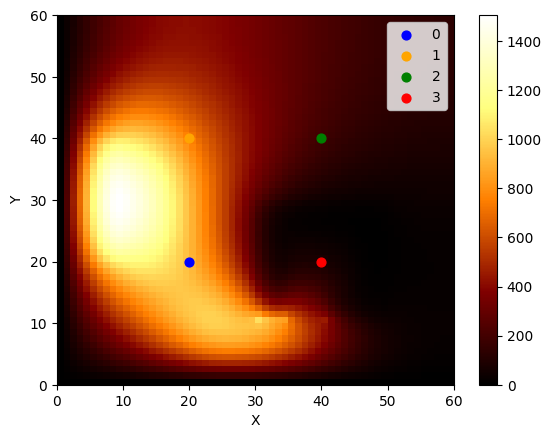

In [11]:
with open(f"tmp/{N[0]}_data.npy", 'rb') as file:
    probe_data = np.load(file)
    dt = np.load(file)
    T_data = np.load(file)
    D = np.load(file)

plt.pcolormesh(T_data[0], cmap='afmhot')
plt.xlabel('X')
plt.ylabel('Y')
plt.colorbar()
probe_0 = [int((N[0]//6) * 2), int((N[0]//6) * 2)]
probe_1 = [int((N[0]//6) * 2), int((N[0]//6) * 4)]
probe_2 = [int((N[0]//6) * 4), int((N[0]//6) * 4)]
probe_3 = [int((N[0]//6) * 4), int((N[0]//6) * 2)]

plt.scatter(*probe_0, label='$'+probe_names[0]+'$', color='blue', s=40)
plt.scatter(*probe_1, label='$'+probe_names[1]+'$', color='orange', s=40)
plt.scatter(*probe_2, label='$'+probe_names[2]+'$', color='green', s=40)
plt.scatter(*probe_3, label='$'+probe_names[3]+'$', color='red', s=40)
plt.legend()

<function matplotlib.pyplot.show(close=None, block=None)>

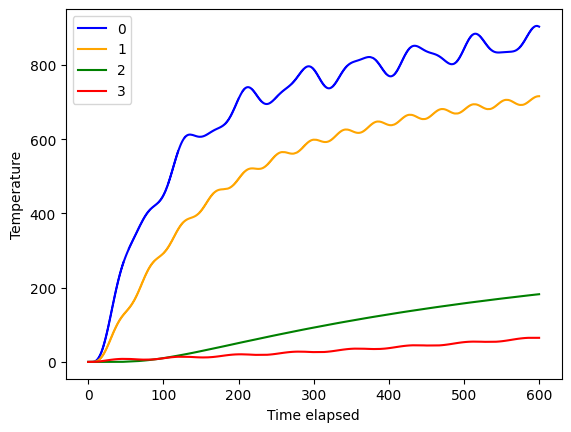

In [12]:
x = np.arange(0, total_time, dt)
plt.plot(x, probe_data[0], label=probe_names[0], color='blue')
plt.plot(x, probe_data[1], label=probe_names[1], color='orange')
plt.plot(x, probe_data[2], label=probe_names[2], color='green')
plt.plot(x, probe_data[3], label=probe_names[3], color='red')
plt.xlabel('Time elapsed')
plt.ylabel('Temperature')
plt.legend()
plt.show

(0.0, 60.0, 0.0, 60.0)

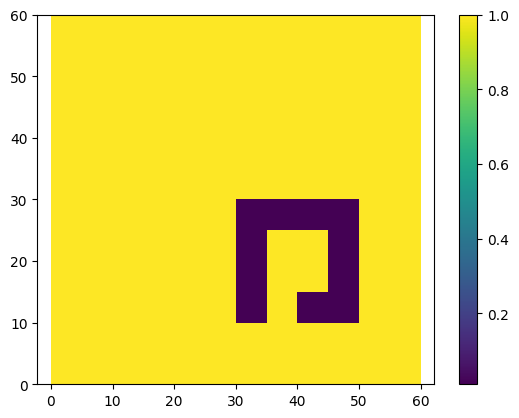

In [13]:
plt.pcolormesh(D)
plt.colorbar()
plt.axis('equal')

In [14]:
print(approximate_period(probe_data[0], dt))
print(approximate_period(probe_data[1], dt))
print(approximate_period(probe_data[2], dt))
print(approximate_period(probe_data[3], dt))

[600.          75.          42.85714286]
[600.          42.85714286]
[600.]
[600.  75.]


## ==================== N = 120 ====================

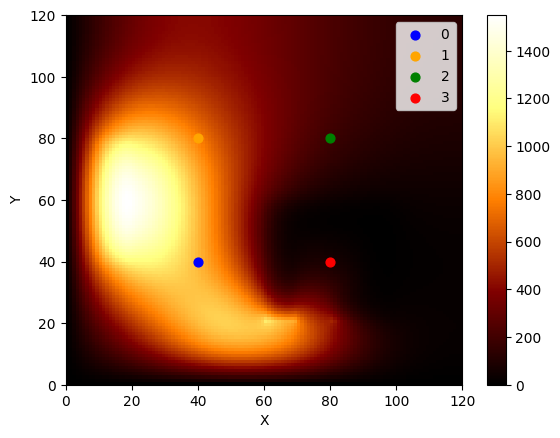

In [15]:
with open(f"tmp/{N[1]}_data.npy", 'rb') as file:
    probe_data = np.load(file)
    dt = np.load(file)
    T_data = np.load(file)
    D = np.load(file)

plt.pcolormesh(T_data[0], cmap='afmhot')
plt.xlabel('X')
plt.ylabel('Y')
plt.colorbar()
probe_0 = [int((N[1]//6) * 2), int((N[1]//6) * 2)]
probe_1 = [int((N[1]//6) * 2), int((N[1]//6) * 4)]
probe_2 = [int((N[1]//6) * 4), int((N[1]//6) * 4)]
probe_3 = [int((N[1]//6) * 4), int((N[1]//6) * 2)]

plt.scatter(*probe_0, label='$'+probe_names[0]+'$', color='blue', s=40)
plt.scatter(*probe_1, label='$'+probe_names[1]+'$', color='orange', s=40)
plt.scatter(*probe_2, label='$'+probe_names[2]+'$', color='green', s=40)
plt.scatter(*probe_3, label='$'+probe_names[3]+'$', color='red', s=40)
plt.legend()

<function matplotlib.pyplot.show(close=None, block=None)>

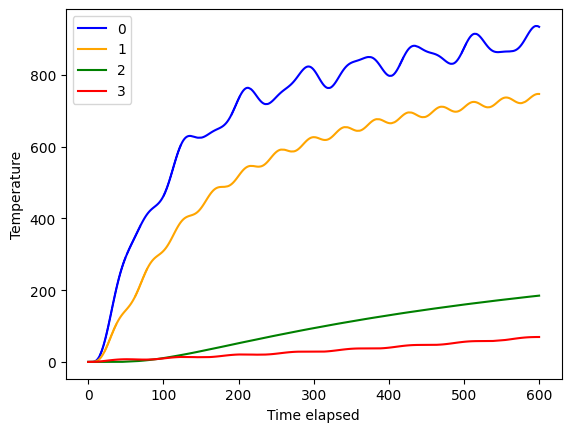

In [16]:
x = np.arange(0, total_time, dt)
plt.plot(x, probe_data[0], label=probe_names[0], color='blue')
plt.plot(x, probe_data[1], label=probe_names[1], color='orange')
plt.plot(x, probe_data[2], label=probe_names[2], color='green')
plt.plot(x, probe_data[3], label=probe_names[3], color='red')
plt.xlabel('Time elapsed')
plt.ylabel('Temperature')
plt.legend()
plt.show

(0.0, 120.0, 0.0, 120.0)

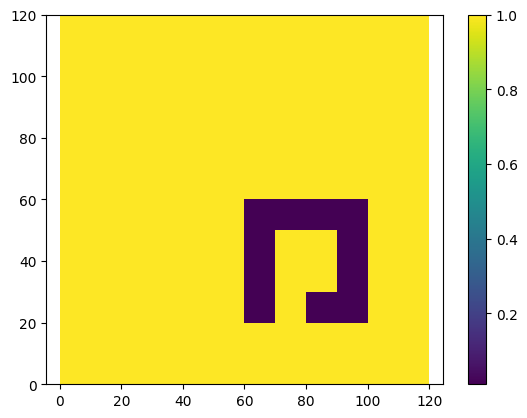

In [17]:
plt.pcolormesh(D)
plt.colorbar()
plt.axis('equal')

In [18]:
print(approximate_period(probe_data[0], dt))
print(approximate_period(probe_data[1], dt))
print(approximate_period(probe_data[2], dt))
print(approximate_period(probe_data[3], dt))

[600.          75.          42.85714286]
[600.          42.85714286]
[600.]
[600.  75.]


## ==================== N = 240 ====================


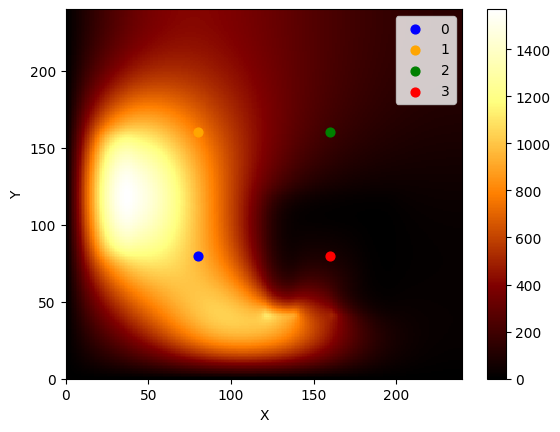

In [19]:
with open(f"tmp/{N[2]}_data.npy", 'rb') as file:
    probe_data = np.load(file)
    dt = np.load(file)
    T_data = np.load(file)
    D = np.load(file)

plt.pcolormesh(T_data[0], cmap='afmhot')
plt.xlabel('X')
plt.ylabel('Y')
plt.colorbar()
probe_0 = [int((N[2]//6) * 2), int((N[2]//6) * 2)]
probe_1 = [int((N[2]//6) * 2), int((N[2]//6) * 4)]
probe_2 = [int((N[2]//6) * 4), int((N[2]//6) * 4)]
probe_3 = [int((N[2]//6) * 4), int((N[2]//6) * 2)]

plt.scatter(*probe_0, label='$'+probe_names[0]+'$', color='blue', s=40)
plt.scatter(*probe_1, label='$'+probe_names[1]+'$', color='orange', s=40)
plt.scatter(*probe_2, label='$'+probe_names[2]+'$', color='green', s=40)
plt.scatter(*probe_3, label='$'+probe_names[3]+'$', color='red', s=40)
plt.legend()

<function matplotlib.pyplot.show(close=None, block=None)>

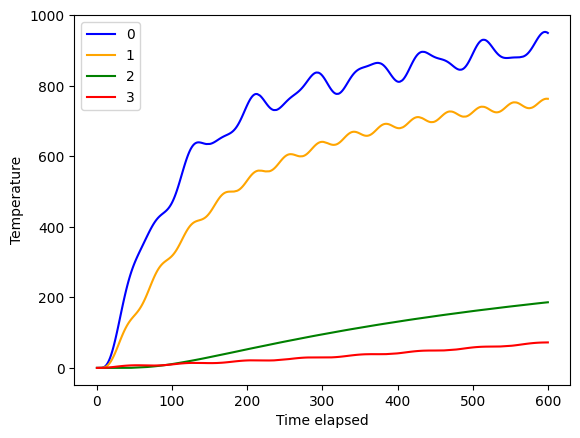

In [20]:
x = np.arange(0, total_time, dt)
plt.plot(x, probe_data[0], label=probe_names[0], color='blue')
plt.plot(x, probe_data[1], label=probe_names[1], color='orange')
plt.plot(x, probe_data[2], label=probe_names[2], color='green')
plt.plot(x, probe_data[3], label=probe_names[3], color='red')
plt.xlabel('Time elapsed')
plt.ylabel('Temperature')
plt.legend()
plt.show

(0.0, 240.0, 0.0, 240.0)

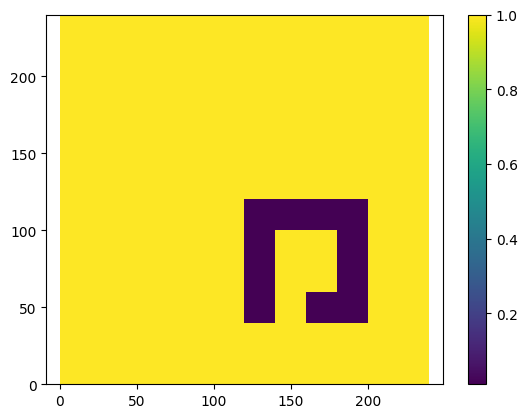

In [21]:
plt.pcolormesh(D)
plt.colorbar()
plt.axis('equal')

In [22]:
print(approximate_period(probe_data[0], dt))
print(approximate_period(probe_data[1], dt))
print(approximate_period(probe_data[2], dt))
print(approximate_period(probe_data[3], dt))

[600.          75.          42.85714286]
[600.          42.85714286]
[600.]
[600.  75.]


## ==================== N = 480 ====================


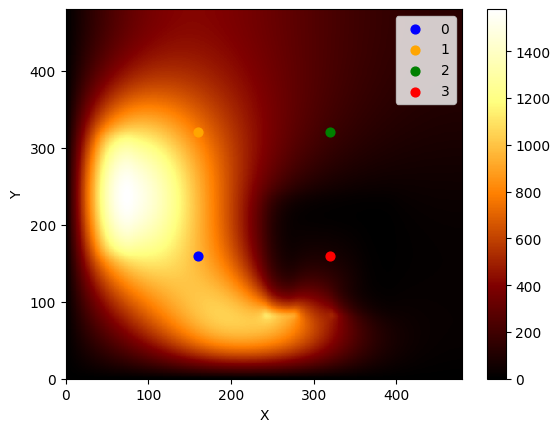

In [23]:
with open(f"tmp/{N[3]}_data.npy", 'rb') as file:
    probe_data = np.load(file)
    dt = np.load(file)
    T_data = np.load(file)
    D = np.load(file)

plt.pcolormesh(T_data[0], cmap='afmhot')
plt.xlabel('X')
plt.ylabel('Y')
plt.colorbar()
probe_0 = [int((N[3]//6) * 2), int((N[3]//6) * 2)]
probe_1 = [int((N[3]//6) * 2), int((N[3]//6) * 4)]
probe_2 = [int((N[3]//6) * 4), int((N[3]//6) * 4)]
probe_3 = [int((N[3]//6) * 4), int((N[3]//6) * 2)]

plt.scatter(*probe_0, label='$'+probe_names[0]+'$', color='blue', s=40)
plt.scatter(*probe_1, label='$'+probe_names[1]+'$', color='orange', s=40)
plt.scatter(*probe_2, label='$'+probe_names[2]+'$', color='green', s=40)
plt.scatter(*probe_3, label='$'+probe_names[3]+'$', color='red', s=40)
plt.legend()

<function matplotlib.pyplot.show(close=None, block=None)>

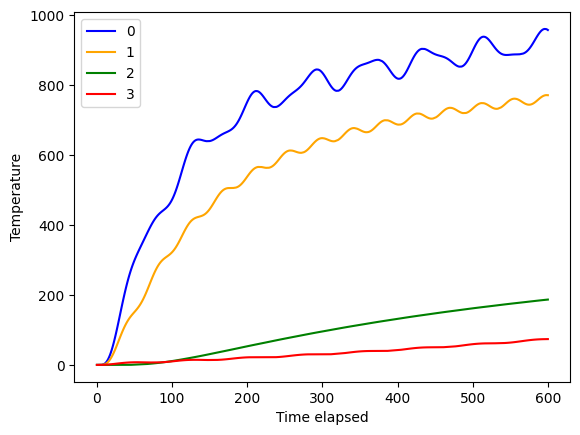

In [24]:
x = np.arange(0, total_time, dt)
plt.plot(x, probe_data[0], label=probe_names[0], color='blue')
plt.plot(x, probe_data[1], label=probe_names[1], color='orange')
plt.plot(x, probe_data[2], label=probe_names[2], color='green')
plt.plot(x, probe_data[3], label=probe_names[3], color='red')
plt.xlabel('Time elapsed')
plt.ylabel('Temperature')
plt.legend()
plt.show

(0.0, 480.0, 0.0, 480.0)

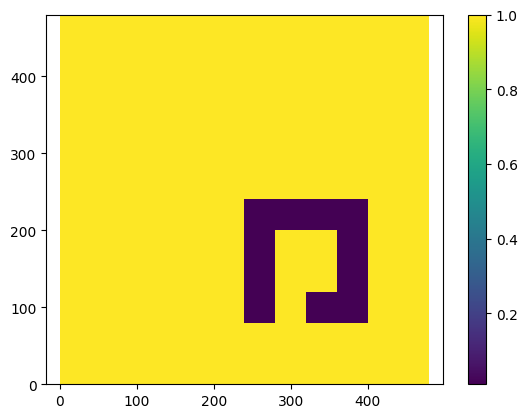

In [25]:
plt.pcolormesh(D)
plt.colorbar()
plt.axis('equal')

In [26]:
print(approximate_period(probe_data[0], dt))
print(approximate_period(probe_data[1], dt))
print(approximate_period(probe_data[2], dt))
print(approximate_period(probe_data[3], dt))

[600.          75.          42.85714286]
[600.          42.85714286]
[600.]
[600.  75.]


## ==================== N = 960 ====================


In [27]:
with open(f"tmp/{N[4]}_data.npy", 'rb') as file:
    probe_data = np.load(file)
    dt = np.load(file)
    T_data = np.load(file)
    D = np.load(file)

plt.pcolormesh(T_data[0], cmap='afmhot')
plt.xlabel('X')
plt.ylabel('Y')
plt.colorbar()
probe_0 = [int((N[4]//6) * 2), int((N[4]//6) * 2)]
probe_1 = [int((N[4]//6) * 2), int((N[4]//6) * 4)]
probe_2 = [int((N[4]//6) * 4), int((N[4]//6) * 4)]
probe_3 = [int((N[4]//6) * 4), int((N[4]//6) * 2)]

plt.scatter(*probe_0, label='$'+probe_names[0]+'$', color='blue', s=40)
plt.scatter(*probe_1, label='$'+probe_names[1]+'$', color='orange', s=40)
plt.scatter(*probe_2, label='$'+probe_names[2]+'$', color='green', s=40)
plt.scatter(*probe_3, label='$'+probe_names[3]+'$', color='red', s=40)
plt.legend()

FileNotFoundError: [Errno 2] No such file or directory: '960_data.npy'

In [ ]:
x = np.arange(0, total_time, dt)
plt.plot(x, probe_data[0], label=probe_names[0], color='blue')
plt.plot(x, probe_data[1], label=probe_names[1], color='orange')
plt.plot(x, probe_data[2], label=probe_names[2], color='green')
plt.plot(x, probe_data[3], label=probe_names[3], color='red')
plt.xlabel('Time elapsed')
plt.ylabel('Temperature')
plt.legend()
plt.show

In [ ]:
plt.pcolormesh(D)
plt.colorbar()
plt.axis('equal')

In [ ]:
print(approximate_period(probe_data[0], dt))
print(approximate_period(probe_data[1], dt))
print(approximate_period(probe_data[2], dt))
print(approximate_period(probe_data[3], dt))